In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

from scipy.spatial.distance import cdist
# Genetic algorithm
import pygad
# Iris data set
from sklearn import datasets
# kmeans clustering
from sklearn.cluster import KMeans
import logging

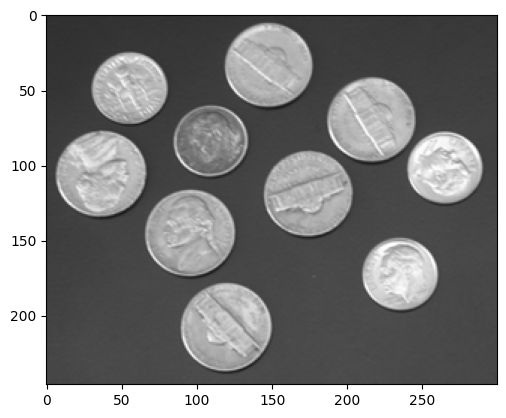

In [2]:
ground_truth = cv.imread("Coins-GT.png")
image = cv.imread('coins.png')

image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

plt.imshow(image)

In [3]:
pixel_val = image.reshape((-1, 3))

pixel_val_float = np.float32(pixel_val)

## Traditional K-means clustering

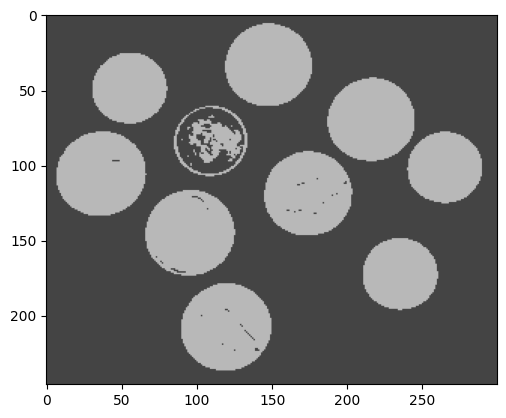

In [4]:
# defining criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 1, 0.85)

k = 2
retval, labels, centers = cv.kmeans(pixel_val_float, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]

# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))
 
plt.imshow(segmented_image)

In [5]:
print(centers)

[[184 184 184]
 [ 68  68  68]]


## Convert to Binary Image

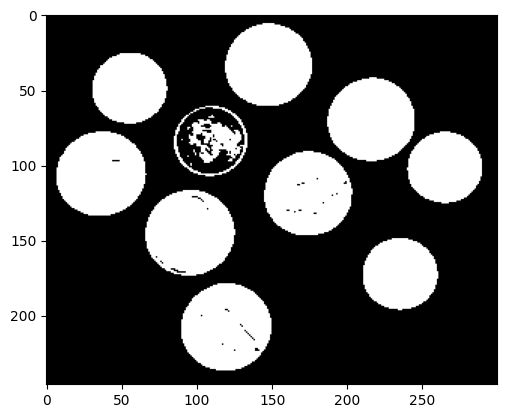

In [6]:
gray_OG = cv.cvtColor(segmented_image, cv.COLOR_RGB2GRAY)

# apply thresholding to convert grayscale to binary image
ret,binary_OG = cv.threshold(gray_OG,70,255,cv.THRESH_BINARY)

gray_GT = cv.cvtColor(ground_truth, cv.COLOR_RGB2GRAY)
ret,binary_GT = cv.threshold(gray_GT,70,255,cv.THRESH_BINARY)

plt.imshow(binary_OG, cmap = 'gray')

## Evaluation using Peak Signal to Noise Ratio (PSNR)

In [7]:
from math import log10, sqrt 
  
def PSNR(ground_truth, clustered): 
    mse = np.mean((ground_truth - clustered) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 


In [8]:
value1 = PSNR(binary_GT, binary_OG) 
print(f"PSNR value is {value1} dB") 


PSNR value is 65.20368160829824 dB


## Morphological Operations

In [9]:
kernel = np.ones((5, 5), np.uint8) 

In [10]:
original_erosion = cv.erode(binary_OG, kernel, iterations=1) 
original_dilation = cv.dilate(binary_OG, kernel, iterations=1) 

original_opening = cv.erode(binary_OG, kernel, iterations=1) 
original_closing = cv.dilate(binary_OG, kernel, iterations=1) 

Text(0.5, 1.0, 'Closing')

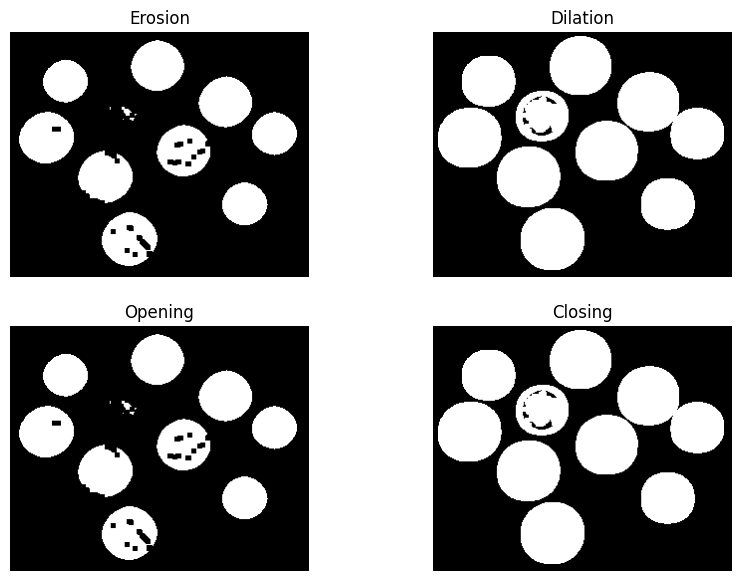

In [11]:
# create figure 
fig = plt.figure(figsize=(10, 7)) 
  
# setting values to rows and column variables 
rows = 2
columns = 2

# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1) 
  
# showing image 
plt.imshow(original_erosion, cmap = 'gray') 
plt.axis('off') 
plt.title("Erosion") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2) 
  
# showing image 
plt.imshow(original_dilation, cmap = 'gray') 
plt.axis('off') 
plt.title("Dilation") 
  
# Adds a subplot at the 3rd position 
fig.add_subplot(rows, columns, 3) 
  
# showing image 
plt.imshow(original_opening, cmap = 'gray') 
plt.axis('off') 
plt.title("Opening") 
  
# Adds a subplot at the 4th position 
fig.add_subplot(rows, columns, 4) 
  
# showing image 
plt.imshow(original_closing, cmap = 'gray') 
plt.axis('off') 
plt.title("Closing") 

In [12]:
psnr_OE = PSNR(binary_OG, original_erosion) 
psnr_OD = PSNR(binary_OG, original_dilation) 
psnr_OO = PSNR(binary_OG, original_opening) 
psnr_OC = PSNR(binary_OG, original_closing) 

print("PSNR value of original K-means after morphological operations")
print("==============================================================")
print(f"Erosion: {psnr_OE} dB") 
print(f"Dilation: {psnr_OD} dB") 
print(f"Opening: {psnr_OO} dB") 
print(f"Closing: {psnr_OC} dB") 

PSNR value of original K-means after morphological operations
Erosion: 59.652169052573726 dB
Dilation: 59.52377247523078 dB
Opening: 59.652169052573726 dB
Closing: 59.52377247523078 dB


## Genetic Algorithm

In [13]:
x = np.float32(pixel_val)

In [14]:
x_min = x.min()
x_max = x.max()

print('Minimum value: {}'.format(x_min))
print('Maximum value: {}'.format(x_max))

Minimum value: 23.0
Maximum value: 255.0


In [15]:
def kmeans(solution, solutionIndex):
    # Global vars
    global x, k
    
    # Centroids
    centroids = np.array(solution).reshape(k, len(solution) // k)
    
    # Finding the distance between centroids and all data points
    distances = cdist(x, centroids, 'euclidean')
    
    # Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances])
    
    # Calculate the sum square error
    error = []
    
    for idx in np.unique(points):
        temp_cent = x[points == idx]
        distances = cdist(temp_cent, centroids[idx].reshape(1, -1), 'euclidean')
    error.append(distances.sum())
                      
    # Return result
    return np.sum(error)


In [16]:
# Fitness function
def fitnessFunction(instance, solution, solutionIndex):
    outputExpected = kmeans(solution, solutionIndex)
    fitnessValue = 1 / (outputExpected + 0.00001)
    return fitnessValue


In [17]:
# Prepare the parameters

# Generation
numberGeneration = 3 # Number of generation
numberParentsMating = 2

parents = -1

solutionPerPopulation = 10

# Genes
numberGenes = k * x.shape[1] # Number of genes in each chromosome

geneType = float # Data type in each gene

# Range of values
minValue = x_min # Minimum value of solution
maxValue = x_max # Maximum value of solution

# Selection
selectionType = 'sss' # Steady state selection

# Cross over
crossoverType = 'single_point' # Cross over with single point method
crossoverRate = 0.25 # Cross over rate (Pc)

# Mutation
mutationType = 'random' # Mutation using random method
mutationReplacement = True # Replace gene with random value
mutationMin = x_min
mutationMax = x_max
mutationRate = 10 # Mutation rate (Pm)


In [18]:
clist = []
for i in range (2):
    for j in range(3):
        clist.append(centers[i][j])
        
cArray = []
        
for i in range(solutionPerPopulation):
    cArray.append(clist)
        
cArray = np.array(cArray) # initialize all solutions within initial population with centroids from cv.kmeans()

print("Initial Population")
print("===================")
print(cArray)

Initial Population
[[184 184 184  68  68  68]
 [184 184 184  68  68  68]
 [184 184 184  68  68  68]
 [184 184 184  68  68  68]
 [184 184 184  68  68  68]
 [184 184 184  68  68  68]
 [184 184 184  68  68  68]
 [184 184 184  68  68  68]
 [184 184 184  68  68  68]
 [184 184 184  68  68  68]]


In [19]:
# Set the parameters into Genetic Algorithm function
geneticAlgorithm = pygad.GA(
    # Number of generation
    num_generations = numberGeneration,
    # Number of parents mating
    num_parents_mating = numberParentsMating,
    # Number of gene each chromosome
    num_genes = numberGenes,
    # Gene type
    gene_type = geneType,
    # Fitness function
    fitness_func = fitnessFunction,
    # Number solution per population
    sol_per_pop = solutionPerPopulation,
    # Min and max value
    init_range_low = minValue,
    init_range_high = maxValue,
    # Selection
    parent_selection_type = selectionType,
    keep_parents = parents,
    # Cross over
    crossover_type = crossoverType,
    crossover_probability = crossoverRate,
    # Mutation
    mutation_type = mutationType,
    mutation_by_replacement = mutationReplacement,
    random_mutation_min_val = mutationMin,
    random_mutation_max_val = mutationMax,
    mutation_percent_genes = mutationRate,
    # Solutions
    save_solutions = True,
    save_best_solutions = True,
    suppress_warnings = True,
    initial_population = cArray
)

In [20]:
geneticAlgorithm.run()

In [21]:
# Solution
solution, solutionFitness, solutionIndex = geneticAlgorithm.best_solution()

# Best solution
print('Parameters of the best solution: \n{solution}'.format(
solution = solution.reshape(k, len(solution) // k)
)
)
# Fitness value for best solution
print('Fitness value of the best solution: {solutionFit}'.format(
solutionFit = round(solutionFitness, ndigits = 2)
)
)
# Index for best solution
print('Index of the best solution: {solutionIndex}'.format(
solutionIndex = solutionIndex
)
)

Parameters of the best solution: 
[[115.18659108 184.         137.21443257]
 [ 68.          68.          68.        ]]
Fitness value of the best solution: 0.0
Index of the best solution: 0


In [22]:
# Final centroids
centroids = solution.reshape(k, len(solution) // k)
# Finding the distance between centroids and all data points
distances = cdist(x, centroids, 'euclidean')
# Centroid with the minimum Distance
points = np.array([np.argmin(i) for i in distances])

In [23]:
print(centroids)
print(centers)

[[115.18659108 184.         137.21443257]
 [ 68.          68.          68.        ]]
[[184 184 184]
 [ 68  68  68]]


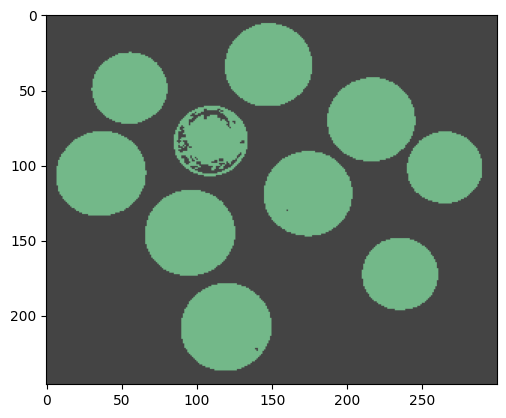

In [24]:
# convert data into 8-bit values
centers = np.uint8(centroids)
segmented_data_clustered = centers[points.flatten()]
 
# reshape data into the original image dimensions
segmented_image_clustered = segmented_data_clustered.reshape((image.shape))
    
plt.imshow(segmented_image_clustered)

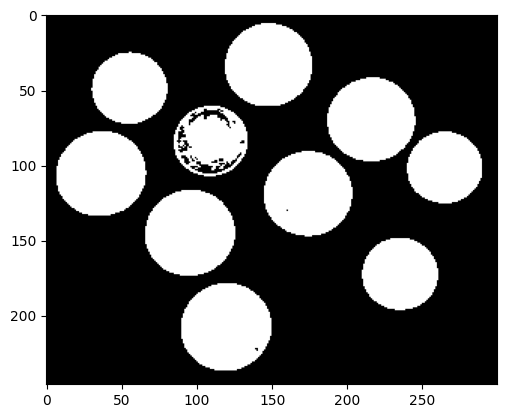

In [25]:
gray_GA = cv.cvtColor(segmented_image_clustered, cv.COLOR_RGB2GRAY)

# apply thresholding to convert grayscale to binary image
ret,binary_GA = cv.threshold(gray_GA,70,255,cv.THRESH_BINARY)

plt.imshow(binary_GA, cmap = 'gray')

In [26]:
value1_GA = PSNR(binary_GT, binary_GA) 
print(f"PSNR value is {value1_GA} dB") 

PSNR value is 70.4565297587604 dB


In [27]:
erosion_GA = cv.erode(binary_GA, kernel, iterations=1) 
dilation_GA = cv.dilate(binary_GA, kernel, iterations=1) 

opening_GA = cv.erode(dilation_GA, kernel, iterations=1) 
closing_GA = cv.dilate(erosion_GA, kernel, iterations=1) 

Text(0.5, 1.0, 'Closing')

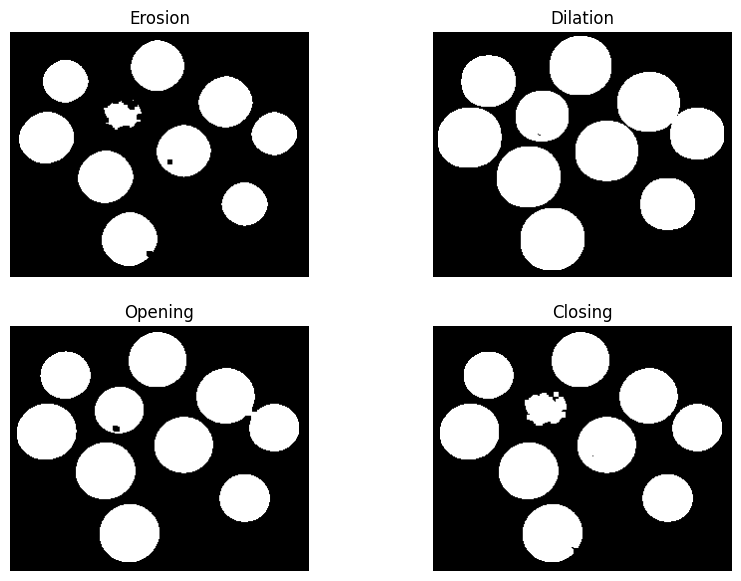

In [28]:
# create figure 
fig = plt.figure(figsize=(10, 7)) 
  
# setting values to rows and column variables 
rows = 2
columns = 2

# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1) 
  
# showing image 
plt.imshow(erosion_GA, cmap = 'gray') 
plt.axis('off') 
plt.title("Erosion") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2) 
  
# showing image 
plt.imshow(dilation_GA, cmap = 'gray') 
plt.axis('off') 
plt.title("Dilation") 
  
# Adds a subplot at the 3rd position 
fig.add_subplot(rows, columns, 3) 
  
# showing image 
plt.imshow(opening_GA, cmap = 'gray') 
plt.axis('off') 
plt.title("Opening") 
  
# Adds a subplot at the 4th position 
fig.add_subplot(rows, columns, 4) 
  
# showing image 
plt.imshow(closing_GA, cmap = 'gray') 
plt.axis('off') 
plt.title("Closing") 

In [29]:
psnr_GE = PSNR(binary_OG, erosion_GA) 
psnr_GD = PSNR(binary_OG, dilation_GA) 
psnr_GO = PSNR(binary_OG, opening_GA) 
psnr_GC = PSNR(binary_OG, closing_GA) 

print("PSNR value of original metahuristic-optimized K-means after morphological operations")
print("==============================================================")
print(f"Erosion: {psnr_GE} dB") 
print(f"Dilation: {psnr_GD} dB") 
print(f"Opening: {psnr_GO} dB") 
print(f"Closing: {psnr_GC} dB") 

PSNR value of original metahuristic-optimized K-means after morphological operations
Erosion: 60.62147802326018 dB
Dilation: 59.13387355345372 dB
Opening: 65.50802954195946 dB
Closing: 66.80702645211633 dB
